In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Gradient with Torch

## Gradient of a Function

We define a function:

$$
y = x^2
$$

We want to get a gradient of $y$ with respect to $x$. Analytically, we know that the gradient is $2x$. Let's see how we can get this with PyTorch.

In [2]:
x = torch.linspace(-2,2, 100, requires_grad=True)

def func(x):
    return torch.square(x)

y = func(x)

def grad_func(x):
    return 2*x

Let's plot them:

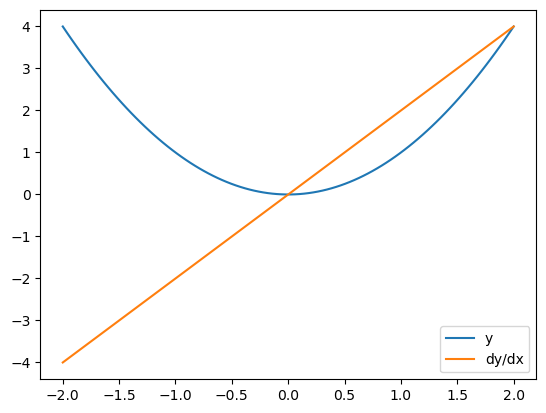

In [3]:
x_numpy = x.detach().numpy()
y_numpy = y.detach().numpy()
dydx_numpy = grad_func(x_numpy)
plt.plot(x_numpy, y_numpy, label='y')
plt.plot(x_numpy, dydx_numpy, label='dy/dx')
plt.legend()
plt.show()

Now, we will use PyTorch to get the gradient of $y$ with respect to $x$.

In [4]:
y.backward(torch.ones_like(x), retain_graph=True)
grad_backward__ = x.grad.detach().numpy()
grad_backward = np.copy(grad_backward__)

> If you want to do `backward` more than once, specify `retain_graph=True` in `backward`.

Let's plot them:

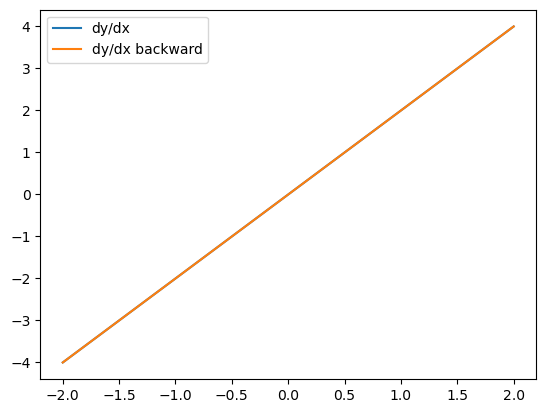

In [5]:
plt.plot(x_numpy, dydx_numpy, label='dy/dx')
plt.plot(x_numpy, grad_backward, label='dy/dx backward')
plt.legend();

Great!

There is another way we can calculate the derivative.  By using `autograd.grad`

In [6]:
grad_auto_ = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(x), retain_graph=True)[0]
grad_auto = grad_auto_.detach().numpy()

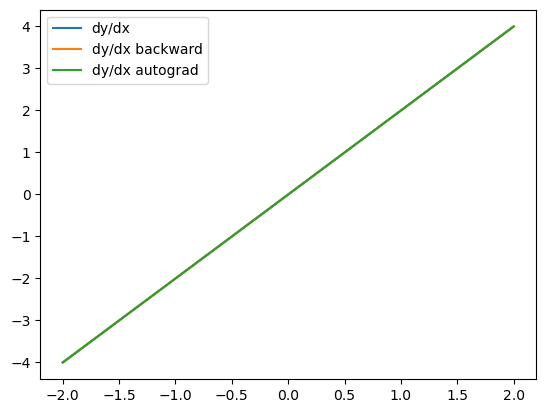

In [7]:
plt.plot(x_numpy, dydx_numpy, label='dy/dx')
plt.plot(x_numpy, grad_backward, label='dy/dx backward')
plt.plot(x_numpy, grad_auto, label='dy/dx autograd')
plt.legend();

The `backward` and `grad` methods are equivalent.

## Gradient of an NN

A neural network is nothing but a function. We can get the gradient of a neural network with respect to its parameters. Let's see how we can do this.

First, we need to create and train a model which learns the given function.

In [8]:
m = nn.Sequential(
    nn.Linear(1, 10),
    nn.Tanh(),
    nn.Linear(10, 20),
    nn.Tanh(),
    nn.Linear(20, 1)
)

This model should be able to learn the function.

Netx, create the loss function.

In [9]:
def loss(y_hat, y_true):
    return torch.mean((y_hat - y_true)**2)

This is just the mean squared error.

Now, optimizer:

In [10]:
optimizer = torch.optim.Adam(m.parameters(), lr=0.01)

Now we train:

You will need to reshape the input and output to be a 2D tensor.

In [11]:
x_train = x.unsqueeze(1)
y_train = y.unsqueeze(1)

In [12]:
epochs = 1000
losses = []
for epoch in range(epochs):
    y_pred = m(x_train)
    l = loss(y_pred, y_train)
    optimizer.zero_grad()
    l.backward(retain_graph=True)
    optimizer.step()
    losses.append(l.item())
    if (epoch+1)%200==0:
        print(f"Epoch {epoch+1}/{epochs}, loss={l.item():.4f}")

Epoch 200/1000, loss=0.0020
Epoch 400/1000, loss=0.0007
Epoch 600/1000, loss=0.0003
Epoch 800/1000, loss=0.0001
Epoch 1000/1000, loss=0.0000


Loss is very low. It seems our model has learned the function. Let's verify this.

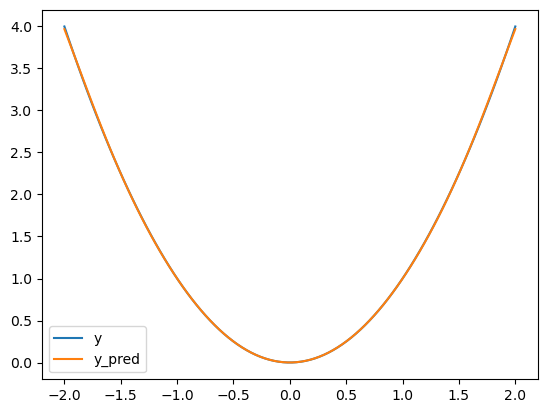

In [13]:
y_pred = m(x_train).detach().numpy()

plt.plot(x_numpy, y_numpy, label='y')
plt.plot(x_numpy, y_pred, label='y_pred')
plt.legend();

Now, the derivative of the model:

In [14]:
output = m(x_train)
output = output.requires_grad_(True)

In [15]:
grad_model_ = torch.autograd.grad(outputs = [output], inputs = [x_train], grad_outputs = torch.ones_like(output) ,
                                  allow_unused=True, retain_graph=True, create_graph=True)[0]
grad_model = grad_model_.detach().numpy()

Let's plot all of them:

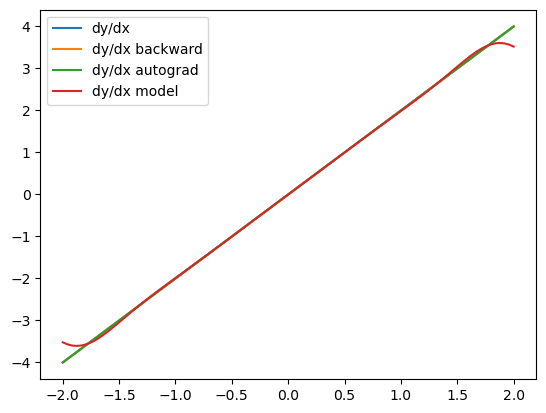

In [16]:
plt.plot(x_numpy, dydx_numpy, label='dy/dx')
plt.plot(x_numpy, grad_backward, label='dy/dx backward')
plt.plot(x_numpy, grad_auto, label='dy/dx autograd')
plt.plot(x_numpy, grad_model, label='dy/dx model')
plt.legend();

We see that the derivative by the model is not exactly the same as the derivative by the analytical method. But this should do.

Let's calculate the second derivative of the model:

In [17]:
second_derivative_ = torch.autograd.grad(outputs = [grad_model_], inputs = [x_train], grad_outputs = torch.ones_like(grad_model_) ,
                                    allow_unused=True, retain_graph=True, create_graph=True)[0]

In [18]:
second_derivative = second_derivative_.detach().numpy()

Analytically, the second derivative of $y=x^2$ is $2$. Let's see how close we are.

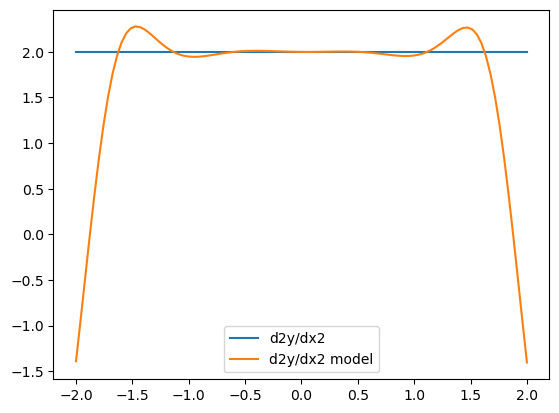

In [19]:
plt.plot(x_numpy, 2*np.ones_like(x_numpy), label='d2y/dx2')
plt.plot(x_numpy, second_derivative, label='d2y/dx2 model')
plt.legend();

Not perfect, but this will do.

> Note that you need to use `tanh` activation if you want to get a second derivative of $y=x^2$. Also, using `ReLU` gives inferior results.

## Two Variables

Next, we will see how we can get the gradient of a function with respect to two variables. We define a function:

$$
u(x, t) = x^2 + 2t^2
$$

The analytical derivatives are:

$$
\frac{\partial u}{\partial x} = 2x
$$
and

$$
\frac{\partial u}{\partial t} = 4t
$$

In [20]:
def dudx(x, t):
    return 2*x

def d2udx2(x, t):
    return 2

def dudt(x,t):
    return 4*t

def d2udt2(x,t):
    return 4

In [21]:
x = torch.linspace(-2,2, 100, requires_grad=True)
t = torch.linspace(-2,2, 100, requires_grad=True)

inputs = torch.stack([x, t], dim=1)
inputs.shape

torch.Size([100, 2])

In [22]:
def func(inputs):
    x, t = inputs[:,0], inputs[:,1]
    return torch.square(x) + 2*torch.square(t)

In [23]:
y = func(inputs)

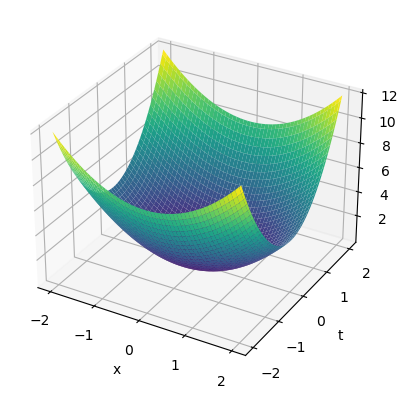

In [24]:
x_numpy = x.detach().numpy()
t_numpy = t.detach().numpy()

Xs, Ts = np.meshgrid(x_numpy, t_numpy)
Zs = Xs**2 + 2*Ts**2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xs, Ts, Zs, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u')
plt.show()

In [25]:
xx_train = torch.from_numpy(Xs.reshape(100*100)).float()
tx_train = torch.from_numpy(Ts.reshape(100*100)).float()
x_train = torch.stack([xx_train, tx_train], dim=1)
x_train = x_train.requires_grad_(True)
y_train = torch.from_numpy(Zs.reshape(100*100)).float()
y_train = y_train.unsqueeze(1)
y_train = y_train.requires_grad_(True)

In [26]:
y.backward(torch.ones_like(y), retain_graph=True)

In [27]:
x_grad_backward = x.grad.detach().numpy()
t_grad_backward = t.grad.detach().numpy()

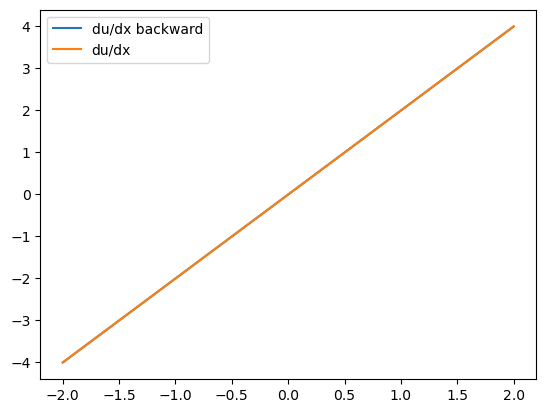

In [28]:
plt.plot(x_numpy, x_grad_backward, label='du/dx backward')
plt.plot(x_numpy, dudx(x_numpy, t_numpy), label='du/dx')
plt.legend();

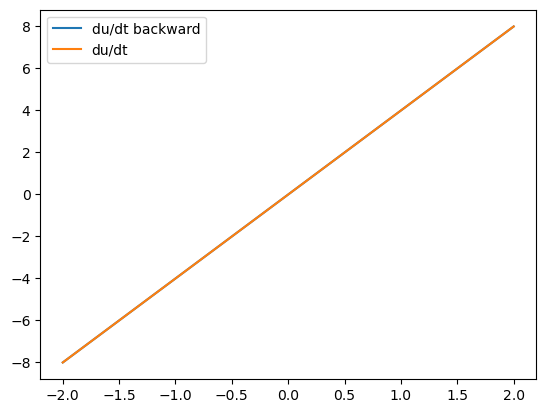

In [29]:
plt.plot(x_numpy, t_grad_backward, label='du/dt backward')
plt.plot(x_numpy, dudt(x_numpy, t_numpy), label='du/dt')
plt.legend();

In [30]:
x_grad_auto = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(x), retain_graph=True)[0]
t_grad_auto = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(t), retain_graph=True)[0]

In [31]:
x_grad_auto = x_grad_auto.detach().numpy()
t_grad_auto = t_grad_auto.detach().numpy()

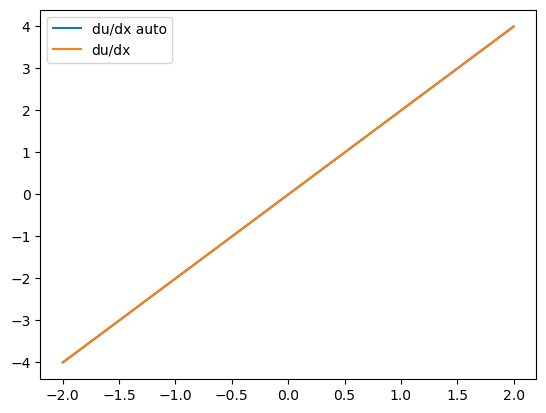

In [32]:
plt.plot(x_numpy, x_grad_auto, label='du/dx auto')
plt.plot(x_numpy, dudx(x_numpy, t_numpy), label='du/dx')
plt.legend();

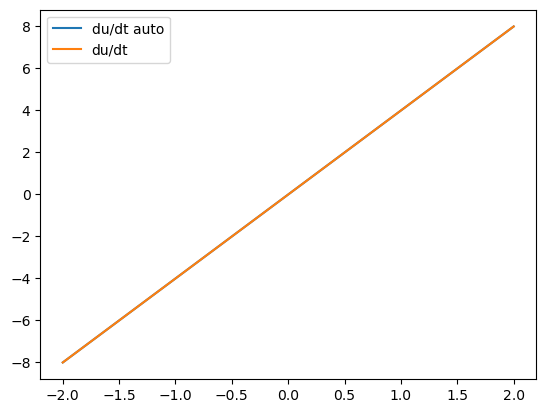

In [33]:
plt.plot(x_numpy, t_grad_auto, label='du/dt auto')
plt.plot(x_numpy, dudt(x_numpy, t_numpy), label='du/dt')
plt.legend();

In [34]:
m = nn.Sequential(
    nn.Linear(2, 10),
    nn.Tanh(),
    nn.Linear(10, 20),
    nn.Tanh(),
    nn.Linear(20, 1)
)

In [35]:
def loss(y_hat, y_true):
    return torch.mean((y_hat - y_true)**2)

optimizer = torch.optim.Adam(m.parameters(), lr=0.01)

In [36]:
epochs = 1000
losses = []
for epoch in range(epochs):
    y_pred = m(x_train)
    l = loss(y_pred, y_train)
    optimizer.zero_grad()
    l.backward(retain_graph=True)
    optimizer.step()
    losses.append(l.item())
    if (epoch+1)%200==0:
        print(f"Epoch {epoch+1}/{epochs}, loss={l.item():.4f}")

Epoch 200/1000, loss=1.5944
Epoch 400/1000, loss=0.0741
Epoch 600/1000, loss=0.0350
Epoch 800/1000, loss=0.0197
Epoch 1000/1000, loss=0.0202


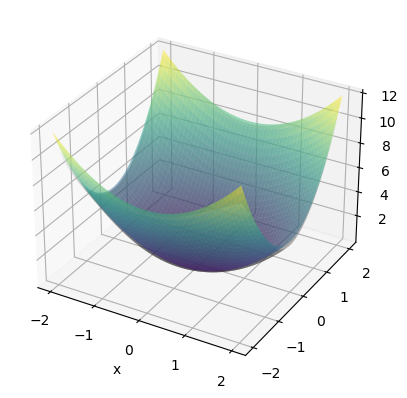

In [37]:
y_pred = m(x_train).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xs, Ts, Zs, cmap='viridis', alpha=0.5)
ax.plot_surface(Xs, Ts, y_pred.reshape(Xs.shape), cmap='gray', alpha=0.5)
ax.set_xlabel('x');

We can see that the model is performing very well. Let's procede.

In [38]:
X_test = torch.linspace(-2,2, 100, requires_grad=True)
T_test = torch.linspace(-2,2, 100, requires_grad=True)

inputs = torch.stack([X_test, T_test], dim=1)

In [39]:
outputs = m(inputs)

In [40]:
grad_model_ = torch.autograd.grad(
    outputs=[outputs],
    inputs=[inputs],
    grad_outputs=torch.ones_like(outputs),
    allow_unused=True,
    retain_graph=True,
    create_graph=True,
)[0]
grad_model = grad_model_.detach().numpy()

In [41]:
dudx_model = grad_model[:, 0]
dudt_model = grad_model[:, 1]

In [42]:
dudx_analytical = dudx(x_numpy, t_numpy)
dudt_analytical = dudt(x_numpy, t_numpy)

assert dudx_model.shape == dudx_analytical.shape

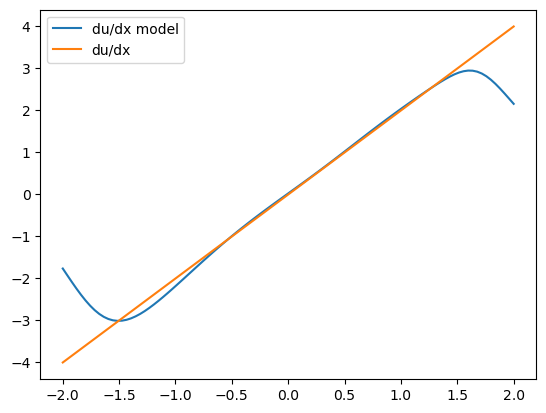

In [43]:
plt.plot(x_numpy, dudx_model, label='du/dx model')
plt.plot(x_numpy, dudx_analytical, label='du/dx')
plt.legend();

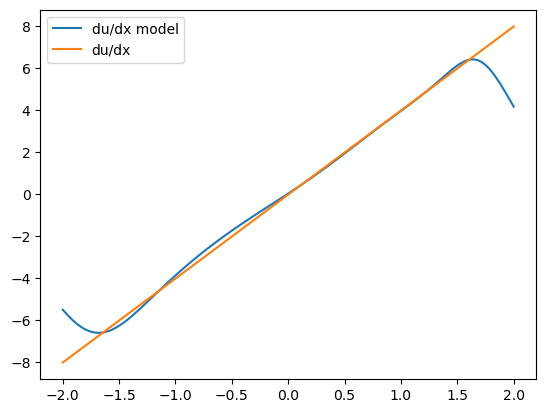

In [44]:
plt.plot(t_numpy, dudt_model, label='du/dx model')
plt.plot(t_numpy, dudt_analytical, label='du/dx')
plt.legend();

Once again, we have good enough results.

What about the second derivative? and other partial derivatives? Specifically, we'll calculate $\frac{\partial^2 u}{\partial x \partial t}$ $\frac{\partial^2 u}{\partial x^2}$ and $\frac{\partial^2 u}{\partial t^2}$.


**Note:** In for $\frac{\partial^2 u}{\partial x^2}$, we have to keep the output to be $\frac{\partial u}{\partial x}$, which is `grad_model_[:, 0]`. Inputs can still be `inputs` but then the required derivative will be the first columns, ie., we need to index `grad_model_[:, 0]`. Also, as we want a differentiation with respect to x, the grad output should be `torch.ones_like(inputs[:, 0])`.

In [45]:
du2dx2_model = torch.autograd.grad(
    outputs=[grad_model_[:, 0]],
    inputs=[inputs],
    grad_outputs=torch.ones_like(grad_model_[:, 0]),
    allow_unused=True,
    retain_graph=True,
    create_graph=True,
)[0][:, 0].detach().numpy()


du2dt2_model = torch.autograd.grad(
    outputs=[grad_model_[:, 1]],
    inputs=[inputs],
    grad_outputs=torch.ones_like(grad_model_[:, 1]),
    allow_unused=True,
    retain_graph=True,
    create_graph=True,
)[0][:, 1].detach().numpy()

du2dxdt_model = torch.autograd.grad(
    outputs=[grad_model_[:, 0]],
    inputs=[inputs],
    grad_outputs=torch.ones_like(grad_model_[:, 1]),
    allow_unused=True,
    retain_graph=True,
    create_graph=True,
)[0][:, 1].detach().numpy()

du2dtdx_model = torch.autograd.grad(
    outputs=[grad_model_[:, 1]],
    inputs=[inputs],
    grad_outputs=torch.ones_like(grad_model_[:, 0]),
    allow_unused=True,
    retain_graph=True,
    create_graph=True,
)[0][:, 0].detach().numpy()

du2dx2_analytical = np.ones_like(x_numpy)*2
du2dt2_analytical = np.ones_like(t_numpy)*4
du2dxdt_analytical = np.zeros_like(x_numpy)
du2dtdx_analytical = np.zeros_like(t_numpy)


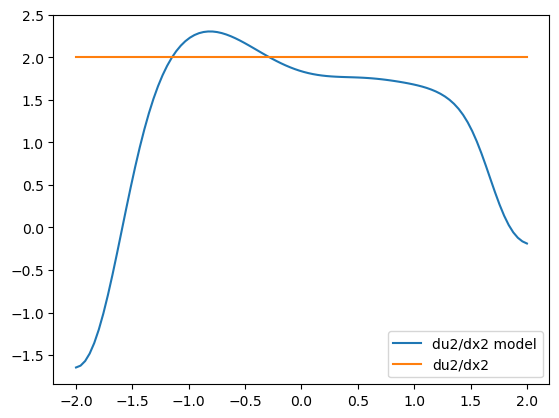

In [46]:
plt.plot(x_numpy, du2dx2_model, label='du2/dx2 model')
plt.plot(x_numpy, du2dx2_analytical, label='du2/dx2')
plt.legend();

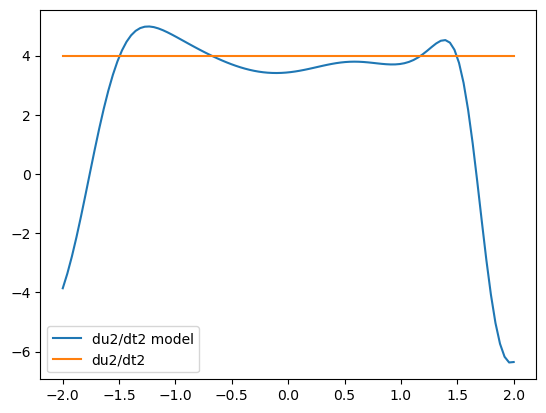

In [47]:
plt.plot(t_numpy, du2dt2_model, label='du2/dt2 model')
plt.plot(t_numpy, du2dt2_analytical, label='du2/dt2')
plt.legend();

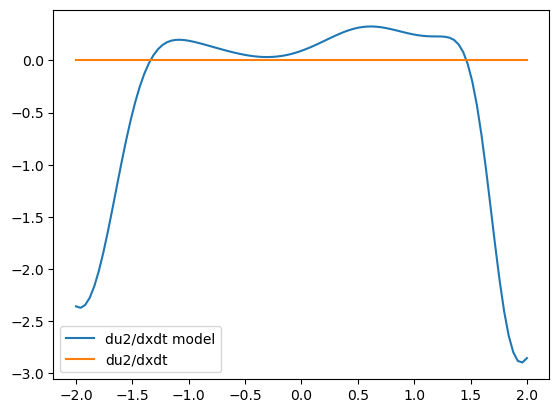

In [48]:
plt.plot(x_numpy, du2dxdt_model, label='du2/dxdt model')
plt.plot(x_numpy, du2dxdt_analytical, label='du2/dxdt')
plt.legend();

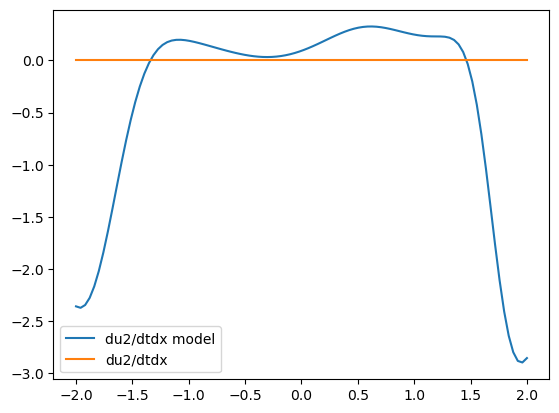

In [49]:
plt.plot(t_numpy, du2dtdx_model, label='du2/dtdx model')
plt.plot(t_numpy, du2dtdx_analytical, label='du2/dtdx')
plt.legend();

So, we are getting somewhat correct answer!